Intrusion Detection System using "https://google.com/"

In [8]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Simulate timestamps
timestamps = [datetime.now() - timedelta(seconds=i*5) for i in range(200)]

# Simulate IPs and ports
google_ip = '142.250.190.78'  # One of Google's IPs
local_ip = '192.168.1.10'

data = []
for t in timestamps:
    is_anomaly = random.random() < 0.1  # 10% anomalies
    entry = {
        'timestamp': t,
        'src_ip': local_ip if not is_anomaly else f'10.0.{random.randint(0,255)}.{random.randint(0,255)}',
        'dst_ip': google_ip,
        'protocol': 'TCP',
        'length': random.randint(40, 1500) if not is_anomaly else random.randint(1500, 3000),
        'src_port': random.randint(1024, 65535),
        'dst_port': 443,
        'anomaly': int(is_anomaly)
    }
    data.append(entry)

df = pd.DataFrame(data)
df.head()

,timestamp,src_ip,dst_ip,protocol,length,src_port,dst_port,anomaly
0,2025-11-05 19:31:24.239435,192.168.1.10,142.250.190.78,TCP,1274,9278,443,0
1,2025-11-05 19:31:19.239435,192.168.1.10,142.250.190.78,TCP,948,6186,443,0
2,2025-11-05 19:31:14.239435,192.168.1.10,142.250.190.78,TCP,839,13302,443,0
3,2025-11-05 19:31:09.239435,192.168.1.10,142.250.190.78,TCP,246,3956,443,0
4,2025-11-05 19:31:04.239435,192.168.1.10,142.250.190.78,TCP,823,5853,443,0


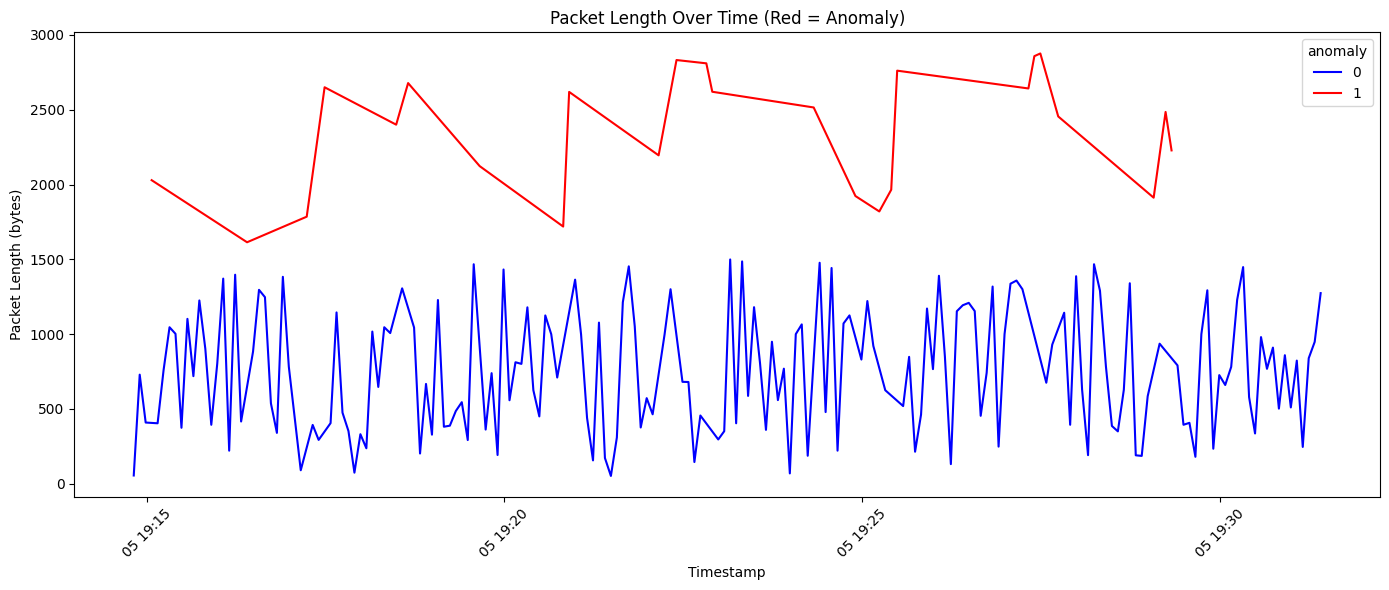

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp to datetime if needed
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by time
df = df.sort_values('timestamp')

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='timestamp', y='length', hue='anomaly', palette={0: 'blue', 1: 'red'})
plt.title('Packet Length Over Time (Red = Anomaly)')
plt.xlabel('Timestamp')
plt.ylabel('Packet Length (bytes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Model training

In [10]:
from sklearn.preprocessing import StandardScaler

# Select features for training
features = ['length', 'src_port', 'dst_port']
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
from sklearn.ensemble import IsolationForest

# Train model
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X_scaled)

# Predict anomalies
df['predicted_anomaly'] = model.predict(X_scaled)
df['predicted_anomaly'] = df['predicted_anomaly'].map({1: 0, -1: 1})  # 1 = normal, -1 = anomaly

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Compare with true labels
print(confusion_matrix(df['anomaly'], df['predicted_anomaly']))
print(classification_report(df['anomaly'], df['predicted_anomaly']))

[[171   4]
 [  9  16]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       175
           1       0.80      0.64      0.71        25

    accuracy                           0.94       200
   macro avg       0.88      0.81      0.84       200
weighted avg       0.93      0.94      0.93       200



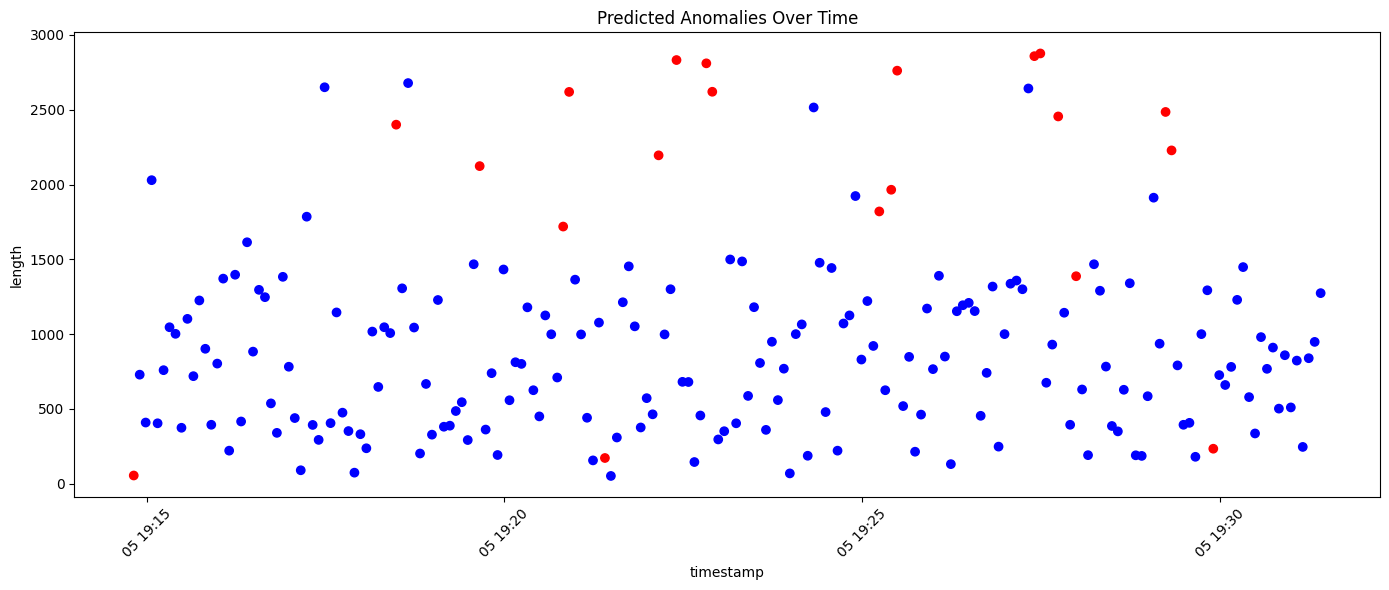

In [20]:
try:
    import plotly.express as px
except Exception:
    import matplotlib.pyplot as plt

    class _DummyFig:
        def __init__(self, fig):
            self._fig = fig
        def show(self):
            plt.show()

    class _DummyPX:
        def scatter(self, df, x, y, color=None, title=None, color_discrete_map=None):
            fig, ax = plt.subplots(figsize=(14, 6))
            if color is not None and color in df.columns:
                cmap = color_discrete_map or {}
                colors = df[color].map(lambda v: cmap.get(v, 'blue'))
            else:
                colors = 'blue'
            ax.scatter(df[x], df[y], c=colors)
            ax.set_title(title or "")
            ax.set_xlabel(x)
            ax.set_ylabel(y)
            plt.xticks(rotation=45)
            plt.tight_layout()
            return _DummyFig(fig)

    px = _DummyPX()

fig = px.scatter(df, x='timestamp', y='length', color='predicted_anomaly',
                 title='Predicted Anomalies Over Time',
                 color_discrete_map={0: 'blue', 1: 'red'})
fig.show()

# SVM

One - SVM

In [21]:
from sklearn.preprocessing import StandardScaler

# Select features
features = ['length', 'src_port', 'dst_port']
X = df[features]

# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [22]:
from sklearn.svm import OneClassSVM

# Train model
svm_model = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
svm_model.fit(X_scaled)

# Predict anomalies
df['svm_predicted_anomaly'] = svm_model.predict(X_scaled)
df['svm_predicted_anomaly'] = df['svm_predicted_anomaly'].map({1: 0, -1: 1})  # 1 = normal, -1 = anomaly

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df['anomaly'], df['svm_predicted_anomaly']))
print(classification_report(df['anomaly'], df['svm_predicted_anomaly']))

[[163  12]
 [ 17   8]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       175
           1       0.40      0.32      0.36        25

    accuracy                           0.85       200
   macro avg       0.65      0.63      0.64       200
weighted avg       0.84      0.85      0.85       200



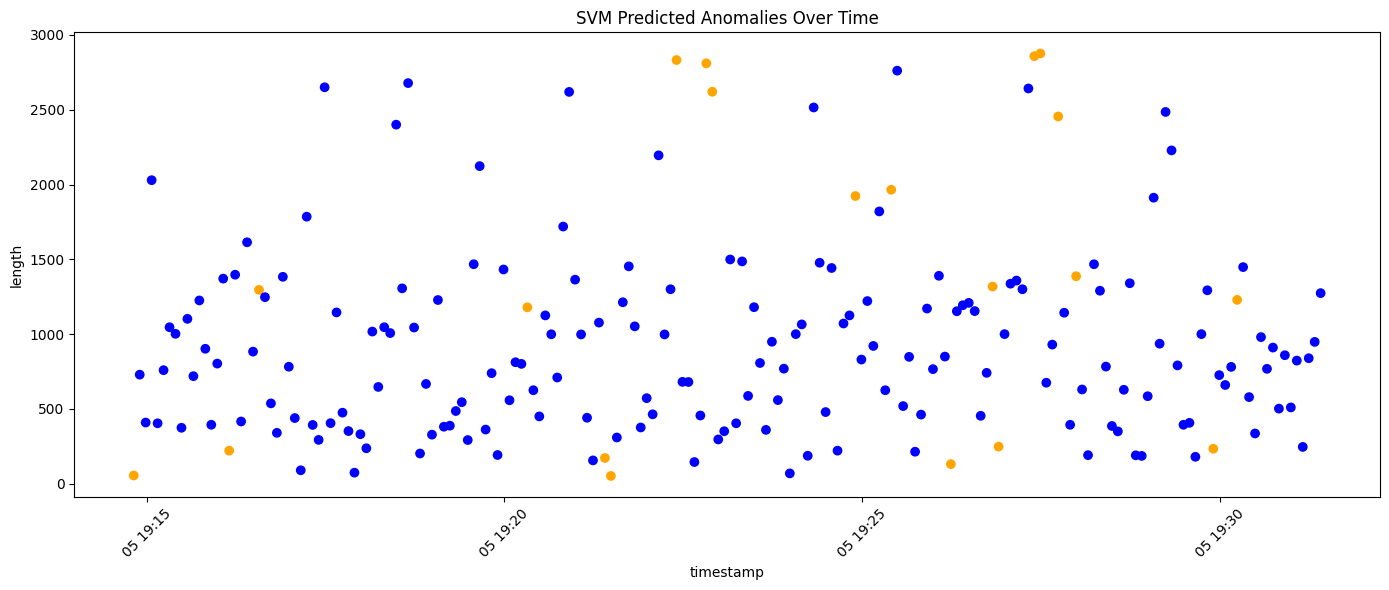

In [25]:
# Use existing px if present; otherwise try to import plotly, else provide a matplotlib fallback
if 'px' not in globals():
    try:
        import plotly.express as px
    except Exception:
        import matplotlib.pyplot as plt

        class _DummyFig:
            def __init__(self, fig):
                self._fig = fig
            def show(self):
                plt.show()

        class _DummyPX:
            def scatter(self, df, x, y, color=None, title=None, color_discrete_map=None):
                fig, ax = plt.subplots(figsize=(14, 6))
                if color is not None and color in df.columns:
                    cmap = color_discrete_map or {}
                    colors = df[color].map(lambda v: cmap.get(v, 'blue'))
                else:
                    colors = 'blue'
                ax.scatter(df[x], df[y], c=colors)
                ax.set_title(title or "")
                ax.set_xlabel(x)
                ax.set_ylabel(y)
                plt.xticks(rotation=45)
                plt.tight_layout()
                return _DummyFig(fig)

        px = _DummyPX()

fig = px.scatter(df, x='timestamp', y='length', color='svm_predicted_anomaly',
                 title='SVM Predicted Anomalies Over Time',
                 color_discrete_map={0: 'blue', 1: 'orange'})
fig.show()

Isolation Forest Vs Confusion matrix comparison

In [26]:
from sklearn.metrics import confusion_matrix

# Isolation Forest
cm_if = confusion_matrix(df['anomaly'], df['predicted_anomaly'])

# One-Class SVM
cm_svm = confusion_matrix(df['anomaly'], df['svm_predicted_anomaly'])

print("Isolation Forest Confusion Matrix:\n", cm_if)
print("One-Class SVM Confusion Matrix:\n", cm_svm)

Isolation Forest Confusion Matrix:
 [[171   4]
 [  9  16]]
One-Class SVM Confusion Matrix:
 [[163  12]
 [ 17   8]]


In [27]:
from sklearn.metrics import classification_report

print("Isolation Forest Report:\n", classification_report(df['anomaly'], df['predicted_anomaly']))
print("One-Class SVM Report:\n", classification_report(df['anomaly'], df['svm_predicted_anomaly']))

Isolation Forest Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       175
           1       0.80      0.64      0.71        25

    accuracy                           0.94       200
   macro avg       0.88      0.81      0.84       200
weighted avg       0.93      0.94      0.93       200

One-Class SVM Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       175
           1       0.40      0.32      0.36        25

    accuracy                           0.85       200
   macro avg       0.65      0.63      0.64       200
weighted avg       0.84      0.85      0.85       200



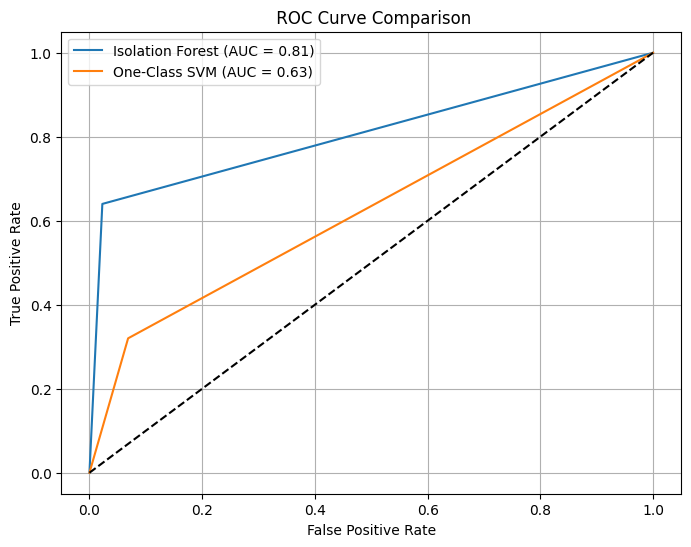

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# True labels
y_true = df['anomaly']

# Scores (simulate with length for demo or use model.decision_function)
y_score_if = df['predicted_anomaly']
y_score_svm = df['svm_predicted_anomaly']

# ROC curves
fpr_if, tpr_if, _ = roc_curve(y_true, y_score_if)
fpr_svm, tpr_svm, _ = roc_curve(y_true, y_score_svm)

# AUC
auc_if = auc(fpr_if, tpr_if)
auc_svm = auc(fpr_svm, tpr_svm)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr_if, tpr_if, label=f'Isolation Forest (AUC = {auc_if:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'One-Class SVM (AUC = {auc_svm:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(' ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
import joblib

joblib.dump(svm_model, 'models/svm_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

In [33]:
import os
from IPython.display import FileLink, display
os.makedirs('data', exist_ok=True)
csv_path = 'data/simulated_google_traffic.csv'
df.to_csv(csv_path, index=False)
print(f"Saved to {csv_path}")

display(FileLink(csv_path))

Saved to data/simulated_google_traffic.csv


c:\Projects\IDS\data\simulated_google_traffic.csv